In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from wrangle import epl_aq_all
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import regex as re

from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

In [2]:
from preprocessing import preprocessing_script

# Project Goals
1. Create a regression of point differential in predicting future points
2. Analyze the importance of draws in pythagorean expectations predictions
3. Predict by placement (classification) especially on relegation side??

# Wrangle Data
Three functions acquiring and prepping data are all available in wrangle.py file.
- 1. `epl_year_aq`: pulls in data frame from season
- 2. `strip_team_name`: takes in season csv and splits and cleans team_name_column 
- 3. `epl_aq_all`: creates df of all seasons of epl
- 4. `rename columns`: renamess columns explicitly
- 5. `make_number_of_seasons`: makes a column for number of seasons

In [3]:
df = epl_aq_all()

In [4]:
print(df.shape)
df.info()

(340, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 12 columns):
team_name            340 non-null object
games_played         340 non-null int64
wins                 340 non-null int64
draws                340 non-null int64
losses               340 non-null int64
goals_for            340 non-null int64
goals_against        340 non-null int64
goal_differential    340 non-null int64
points               340 non-null int64
year                 340 non-null int64
place                340 non-null int64
seasons_in_epl       340 non-null int64
dtypes: int64(11), object(1)
memory usage: 32.0+ KB


In [5]:
df = preprocessing_script(df)

In [6]:
df['goal_percentage'] = df.goals_for / (df.goals_for+df.goals_against)

In [7]:
df['win_rate'] = df.wins / df.losses

In [8]:
df['surpluss_goals'] = df.goal_differential - df.wins

In [9]:
df['points_rate'] = (df.wins + df.draws) / df.losses

In [10]:
df['goals_per_loss'] = df.goals_for/ (df.losses)

In [13]:
(df[['points', 'goal_differential', 'next_season_points', 
     'wins', 'goals_for', 'goals_against', 'place', 'losses', 
     'goal_percentage', 'win_rate', 'surpluss_goals', 'points_rate',
    'goals_per_loss', 'seasons_in_epl']]
     .dropna().corr().next_season_points)

points                0.784466
goal_differential     0.808551
next_season_points    1.000000
wins                  0.760709
goals_for             0.752497
goals_against        -0.699766
place                -0.726295
losses               -0.770751
goal_percentage       0.816789
win_rate              0.571873
surpluss_goals        0.805589
points_rate           0.567617
goals_per_loss        0.604209
seasons_in_epl        0.638860
Name: next_season_points, dtype: float64

#### Overview of the dataframe

In [14]:
print(df.shape)
print(df.info())
df.head(2)

(340, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 19 columns):
team_name             340 non-null object
games_played          340 non-null int64
wins                  340 non-null int64
draws                 340 non-null int64
losses                340 non-null int64
goals_for             340 non-null int64
goals_against         340 non-null int64
goal_differential     340 non-null int64
points                340 non-null int64
year                  340 non-null int64
place                 340 non-null int64
seasons_in_epl        340 non-null int64
finish                340 non-null object
next_season_points    300 non-null float64
goal_percentage       340 non-null float64
win_rate              340 non-null float64
surpluss_goals        340 non-null int64
points_rate           340 non-null float64
goals_per_loss        340 non-null float64
dtypes: float64(5), int64(12), object(2)
memory usage: 50.6+ KB
None


,team_name,games_played,wins,draws,losses,goals_for,goals_against,goal_differential,points,year,place,seasons_in_epl,finish,next_season_points,goal_percentage,win_rate,surpluss_goals,points_rate,goals_per_loss
0,AFC Bournemouth,38,11,9,18,45,67,-22,42,2015,16,4,relegation_battle,46.0,0.401786,0.611111,-33,1.111111,2.5000
1,AFC Bournemouth,38,12,10,16,55,67,-12,46,2016,9,4,mid_table,44.0,0.450820,0.750000,-24,1.375000,3.4375


In [15]:
df.describe()

,games_played,wins,draws,losses,goals_for,goals_against,goal_differential,points,year,place,seasons_in_epl,next_season_points,goal_percentage,win_rate,surpluss_goals,points_rate,goals_per_loss
count,340.0,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.0000,340.00000,340.000000,300.000000,340.000000,340.000000,340.000000,340.000000,340.000000
mean,38.0,14.235294,9.529412,14.235294,50.758824,50.758824,0.000000,52.208824,2010.0000,10.50000,11.941176,53.196667,0.497100,inf,-14.235294,inf,inf
std,0.0,6.023841,2.819394,5.595820,15.492335,13.182430,25.948667,17.242002,4.9062,5.77478,4.839861,17.325277,0.122980,NaN,20.319075,NaN,NaN
min,38.0,1.000000,2.000000,0.000000,20.000000,15.000000,-69.000000,11.000000,2002.0000,1.00000,1.000000,15.000000,0.183486,0.034483,-70.000000,0.310345,0.689655
25%,38.0,10.000000,7.000000,10.000000,41.000000,41.750000,-18.250000,40.000000,2006.0000,5.75000,7.750000,41.000000,0.408303,0.554167,-28.000000,1.111111,2.280952
50%,38.0,13.000000,9.000000,15.000000,47.000000,51.000000,-7.000000,47.500000,2010.0000,10.50000,13.000000,48.500000,0.465347,0.806250,-19.000000,1.533333,3.000000
75%,38.0,18.000000,11.000000,18.000000,59.000000,59.000000,16.500000,63.000000,2014.0000,15.25000,17.000000,64.250000,0.583726,1.771368,-0.750000,2.800000,5.706818
max,38.0,32.000000,17.000000,29.000000,106.000000,89.000000,79.000000,100.000000,2018.0000,20.00000,17.000000,100.000000,0.827586,inf,47.000000,inf,inf


# Explore

### Team Results

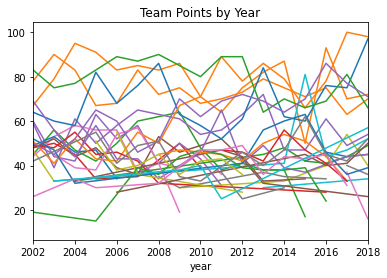

In [16]:
df.set_index('year').groupby('team_name').points.plot()
plt.title('Team Points by Year')
plt.show()

**Takeaways** At the top of the viz, you can see that there are a couple teams that have stayed at the top of the table, but as you get further towards the middle, the data becomes a lot more muddled

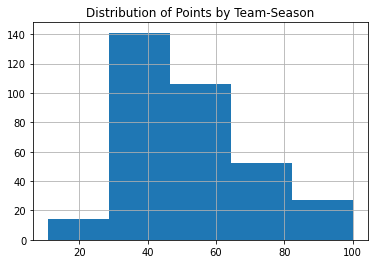

In [17]:
df.points.hist(bins=5)
plt.title("Distribution of Points by Team-Season")
plt.show()

**Takeaways** Looks like a poisson distribution.

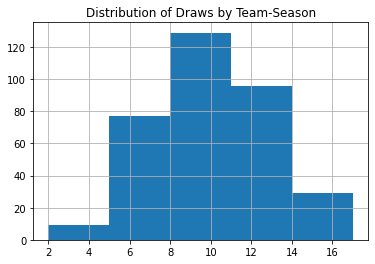

In [18]:
df.draws.hist(bins=5)
plt.title("Distribution of Draws by Team-Season")
plt.show()

**Takeaways** Normal distribution around 9-10 draws per season

In [19]:
df.draws.describe()

count    340.000000
mean       9.529412
std        2.819394
min        2.000000
25%        7.000000
50%        9.000000
75%       11.000000
max       17.000000
Name: draws, dtype: float64

Average number of draws per year is 9.5

### Exploring Draws a little more closely

Text(0.5, 1.0, 'Is There a Pattern for Draws by Table Place?')

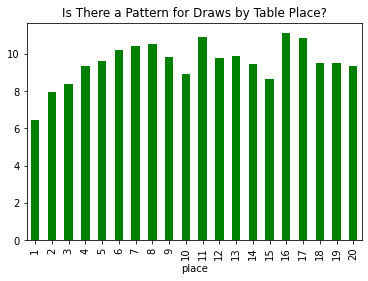

In [20]:
df.groupby('place').draws.mean().plot.bar(color='green')
plt.title('Is There a Pattern for Draws by Table Place?')

**Takeaways** Number of draws tend to be higher at the middle of the table

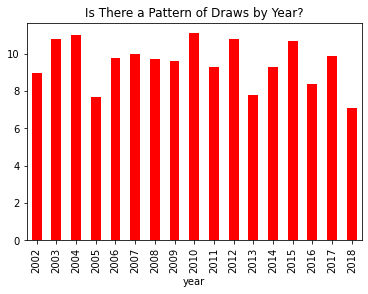

In [21]:
df.groupby('year').draws.mean().plot.bar(color='red')
plt.title('Is There a Pattern of Draws by Year?')
plt.show()

**Takeaways** Not really, there is a pretty significant difference between certain years, but no noticeable trends
**Furtherwork** Some hypothesis testing and statistical analysis

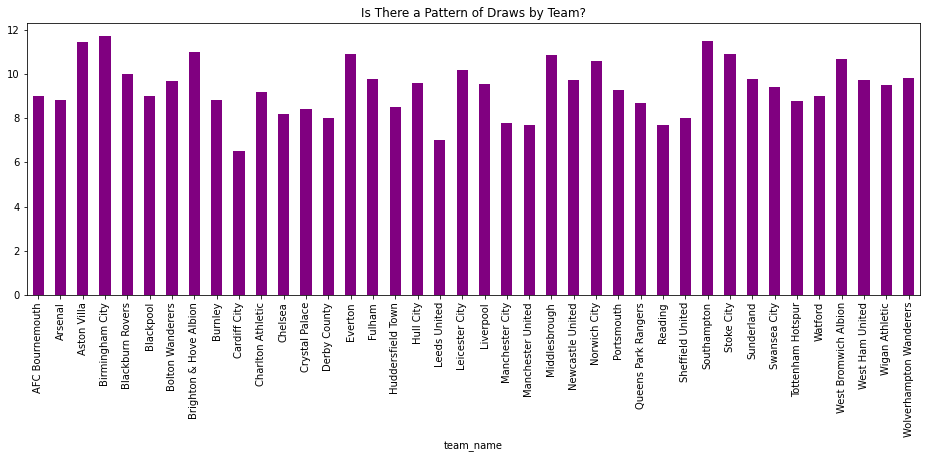

In [22]:
plt.figure(figsize=(16,5))
df.groupby('team_name').draws.mean().plot.bar(color='purple')
plt.title('Is There a Pattern of Draws by Team?')
plt.show()

**Takeaways** Likely, but not immediately evident.

Text(0.5, 1.0, 'Because of Relegation, How Many Seasons Has Each Team Played?')

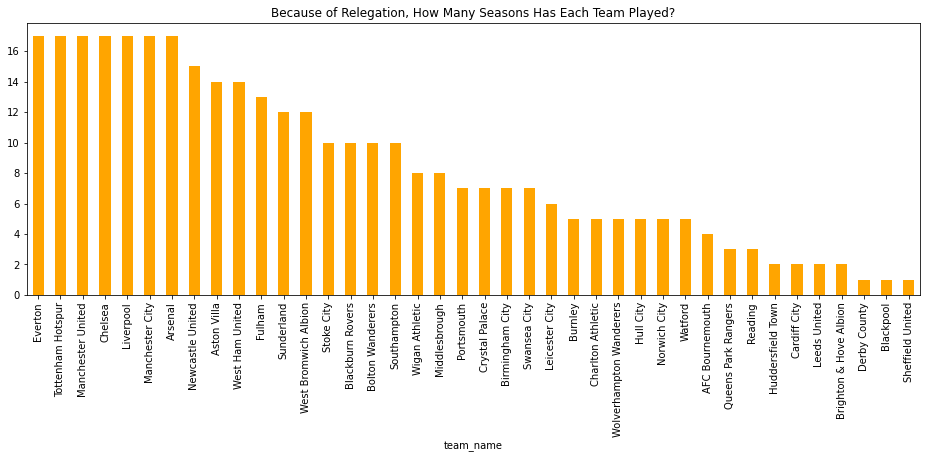

In [23]:
plt.figure(figsize=(16,5))
df.groupby('team_name').draws.count().sort_values(ascending=False).plot.bar(color='orange')
plt.title('Because of Relegation, How Many Seasons Has Each Team Played?')

### Just for fun , lets look at scatter plots of number of seasons and average number of points and draws!

Text(0.5, 1.0, 'What is the Relationship between No of Seasons in EPL and Avg No of Draws')

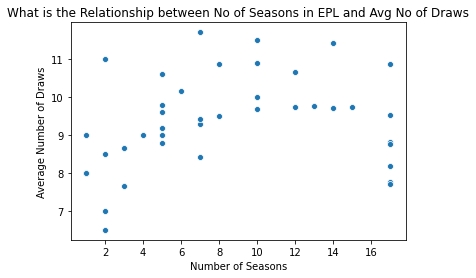

In [24]:
df_temp = df.groupby('team_name').draws.agg(['count', 'mean'])
sns.scatterplot(x='count', y='mean', data=df_temp)
plt.xlabel('Number of Seasons')
plt.ylabel('Average Number of Draws')
plt.title('What is the Relationship between No of Seasons in EPL and Avg No of Draws')

Text(0.5, 1.0, 'What is the Relationship between No of Seasons in EPL and Avg Points')

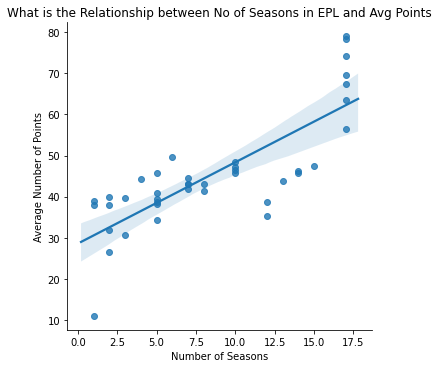

In [25]:
df_temp = df.groupby('team_name').points.agg(['count', 'mean'])
sns.lmplot(x='count', y='mean', data=df_temp)
plt.xlabel('Number of Seasons')
plt.ylabel('Average Number of Points')
plt.title('What is the Relationship between No of Seasons in EPL and Avg Points')

**Takeaways:** Seems to be a pretty clear linear relationship between number of seasons in the Premier League and the Average number of Points

Text(0.5, 1.0, 'What is the relationship between points and goal differential')

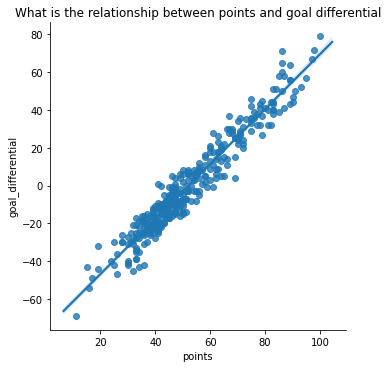

In [26]:
sns.lmplot(x='points', y = 'goal_differential', data = df)
plt.title('What is the relationship between points and goal differential')

Text(0.5, 1.0, 'What is the relationship between points and place')

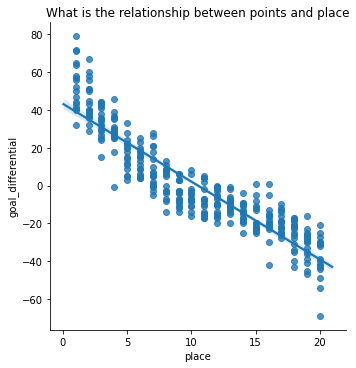

In [27]:
sns.lmplot(x='place', y = 'goal_differential', data = df)
plt.title('What is the relationship between points and place')

### Is it better to win or avoid a loss?

Text(0, 0.5, 'Absolute value of correlation')

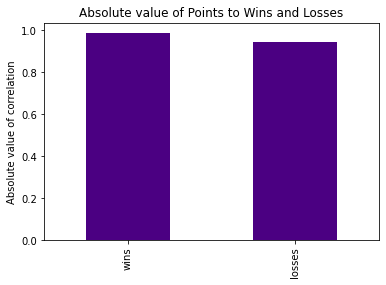

In [28]:
df[['wins', 'losses', 'points']].corr().points[0:2].abs().plot.bar(color='indigo')
plt.title("Absolute value of Points to Wins and Losses")
plt.ylabel('Absolute value of correlation')

**Takeaways:** Although there is a high absolute correlation to both.  It appears that winning is more important than avoiding losses.

Text(0, 0.5, 'Absolute value of correlation')

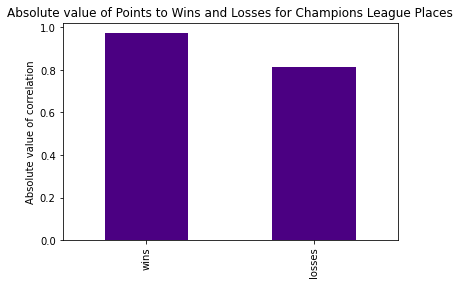

In [29]:
df[df.place <= 4][['wins', 'losses', 'points']].corr().points[0:2].abs().plot.bar(color='indigo')
plt.title("Absolute value of Points to Wins and Losses for Champions League Places")
plt.ylabel('Absolute value of correlation')

Text(0, 0.5, 'Absolute value of correlation')

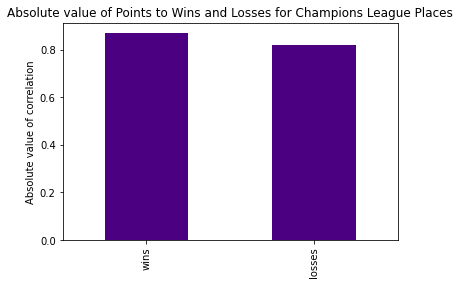

In [30]:
df[df.place >= 18][['wins', 'losses', 'points']].corr().points[0:2].abs().plot.bar(color='indigo')
plt.title("Absolute value of Points to Wins and Losses for Champions League Places")
plt.ylabel('Absolute value of correlation')

# Modeling

In [31]:
df_pred = df[(df.year - (df.next_year - 1)) == 0]

AttributeError: 'DataFrame' object has no attribute 'next_year'

In [ ]:
print(df_pred.shape)
df_pred.info()

In [ ]:
df_pred

In [ ]:
df.dropna(inplace=True)

In [ ]:
X = df[['wins', 'draws', 'losses', 'goals_for', 'goals_against','goal_differential', 'points']]
y = df[['next_season_points']]

In [ ]:
lm = LinearRegression()

In [ ]:
rfe = RFE(lm, 2)

In [ ]:
X_rfe = rfe.fit_transform(X, y)  

In [ ]:
mask = rfe.support_

In [ ]:
# select the column names of the features that were selected and convert them to a list for future use. 
rfe_features = X.columns[mask]

# print them out here for our reference
print(f'selected {len(rfe_features)} features:', ', '.join(rfe_features))

In [32]:
print("Linear Model:", lm)

print("intercept: ", lm.intercept_)

print("features: ", rfe_features)
print("coefficients: ", lm.coef_)

NameError: name 'lm' is not defined

In [34]:
for i in range(320):
    print(

SyntaxError: unexpected EOF while parsing (<ipython-input-34-ca4a670445eb>, line 2)

In [35]:
pd.read_csv>

SyntaxError: invalid syntax (<ipython-input-35-51740e0faf67>, line 1)

In [38]:
for i in df.index:
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [39]:
for i in df.index:
    print(i**2)

0
1
4
9
16
25
36
49
64
81
100
121
144
169
196
225
256
289
324
361
400
441
484
529
576
625
676
729
784
841
900
961
1024
1089
1156
1225
1296
1369
1444
1521
1600
1681
1764
1849
1936
2025
2116
2209
2304
2401
2500
2601
2704
2809
2916
3025
3136
3249
3364
3481
3600
3721
3844
3969
4096
4225
4356
4489
4624
4761
4900
5041
5184
5329
5476
5625
5776
5929
6084
6241
6400
6561
6724
6889
7056
7225
7396
7569
7744
7921
8100
8281
8464
8649
8836
9025
9216
9409
9604
9801
10000
10201
10404
10609
10816
11025
11236
11449
11664
11881
12100
12321
12544
12769
12996
13225
13456
13689
13924
14161
14400
14641
14884
15129
15376
15625
15876
16129
16384
16641
16900
17161
17424
17689
17956
18225
18496
18769
19044
19321
19600
19881
20164
20449
20736
21025
21316
21609
21904
22201
22500
22801
23104
23409
23716
24025
24336
24649
24964
25281
25600
25921
26244
26569
26896
27225
27556
27889
28224
28561
28900
29241
29584
29929
30276
30625
30976
31329
31684
32041
32400
32761
33124
33489
33856
34225
34596
34969
35344
35721
36100


In [40]:
for i in df.index:
    print(i**3)

0
1
8
27
64
125
216
343
512
729
1000
1331
1728
2197
2744
3375
4096
4913
5832
6859
8000
9261
10648
12167
13824
15625
17576
19683
21952
24389
27000
29791
32768
35937
39304
42875
46656
50653
54872
59319
64000
68921
74088
79507
85184
91125
97336
103823
110592
117649
125000
132651
140608
148877
157464
166375
175616
185193
195112
205379
216000
226981
238328
250047
262144
274625
287496
300763
314432
328509
343000
357911
373248
389017
405224
421875
438976
456533
474552
493039
512000
531441
551368
571787
592704
614125
636056
658503
681472
704969
729000
753571
778688
804357
830584
857375
884736
912673
941192
970299
1000000
1030301
1061208
1092727
1124864
1157625
1191016
1225043
1259712
1295029
1331000
1367631
1404928
1442897
1481544
1520875
1560896
1601613
1643032
1685159
1728000
1771561
1815848
1860867
1906624
1953125
2000376
2048383
2097152
2146689
2197000
2248091
2299968
2352637
2406104
2460375
2515456
2571353
2628072
2685619
2744000
2803221
2863288
2924207
2985984
3048625
3112136
3176523
324

In [41]:
for i in df.index:
    print(i**3 - i**2)

0
0
4
18
48
100
180
294
448
648
900
1210
1584
2028
2548
3150
3840
4624
5508
6498
7600
8820
10164
11638
13248
15000
16900
18954
21168
23548
26100
28830
31744
34848
38148
41650
45360
49284
53428
57798
62400
67240
72324
77658
83248
89100
95220
101614
108288
115248
122500
130050
137904
146068
154548
163350
172480
181944
191748
201898
212400
223260
234484
246078
258048
270400
283140
296274
309808
323748
338100
352870
368064
383688
399748
416250
433200
450604
468468
486798
505600
524880
544644
564898
585648
606900
628660
650934
673728
697048
720900
745290
770224
795708
821748
848350
875520
903264
931588
960498
990000
1020100
1050804
1082118
1114048
1146600
1179780
1213594
1248048
1283148
1318900
1355310
1392384
1430128
1468548
1507650
1547440
1587924
1629108
1670998
1713600
1756920
1800964
1845738
1891248
1937500
1984500
2032254
2080768
2130048
2180100
2230930
2282544
2334948
2388148
2442150
2496960
2552584
2609028
2666298
2724400
2783340
2843124
2903758
2965248
3027600
3090820
3154914
32198